In [115]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import math
# from util import findCentroid, rotateImage, halveTheRegionHorizontally, computeAsymmetry

import numpy as np
from PIL import Image
from skimage.measure import find_contours, label
from skimage.morphology import binary_closing
import random
from noise import pnoise2
from PIL import ImageOps
from skimage.color import rgb2lab

# ENV
import os

# ISIC API
import requests
import glob

# Main data structure(s)
import pandas as pd
import numpy as np

# For pi value
import math

# For API calls
import time
import json

# Building a data set
import shutil
import zipfile
from io import BytesIO

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Data normalization
from sklearn import preprocessing

# Feature extraction
from skimage import morphology
from skimage.transform import rotate
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

# Color 'brightness' (value) spread
from skimage.segmentation import slic # Segments image using k-means clustering in Color-(x,y,z) space
from skimage.measure import regionprops
from skimage.color import rgb2hsv # Converts RGB color to HSV (Hue, Saturation, Value)

# Proper split of training and test data
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

# Model building
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

C:\Users\jackh\AppData\Local\Temp\ipykernel_1872\464358712.py:53: DeprecationWarning: Please use `mode` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import mode


Find # of data entries for Melanoma and Seborrheic keratosis

In [116]:
import csv

filename = '../data/metadata.csv'
label_counts = {'MEL': 0, 'SEK': 0}

with open(filename, 'r') as csvfile:
    csvreader = csv.reader(csvfile)

    # Skip the header row
    next(csvreader)

    # Loop over each row in the CSV file
    for row in csvreader:
        # Get the label in column 18
        label = row[17]

        # If the label is 'MEL' or 'SEK', increment the corresponding count
        if label in label_counts:
            label_counts[label] += 1

print('Number of MEL labels:', label_counts['MEL'])
print('Number of SEK labels:', label_counts['SEK'])

Number of MEL labels: 52
Number of SEK labels: 235


Find # of rows where column 17 is either MEL or SEK, but has missing or unknown values for other columns

In [117]:
# columns:
# 2: smoke
# 3: drink alcohol
# 6: age
# 14: region
# 15: diameter_1
# 16: diameter_2
# 18: itch
# 19: grew
# 20 hurt
# 21: changed
# 22: bleed
# 23: elevation

import csv

def count_rows(filename, col_1, col_2=17):
    count = 0
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header row
        for row in reader:
            # if (row[col_1] == '' or row[col_1] == 'UNK' or row[col_1] is None) and row[col_2] in ['MEL', 'SEK']:
            if (row[col_1] == '' or row[col_1] == 'UNK' or row[col_1] is None) and row[col_2] in ['MEL']:
                count += 1
    return count

In [118]:
filename = '../data/metadata.csv'
smoke = 2
age = 6
region = 14
diameter_1 = 15
diameter_2 = 16
itch = 18
grew = 19
hurt = 20
changed = 21
bleed = 22
elevation = 23

print('Number of MEL + SEK labels with no smoke data:', count_rows(filename, smoke))
print('Number of MEL + SEK labels with no age data:', count_rows(filename, age))
print('Number of MEL + SEK labels with no region data:', count_rows(filename, region))
print('Number of MEL + SEK labels with no diameter_1 data:', count_rows(filename, diameter_1))
print('Number of MEL + SEK labels with no diameter_2 data:', count_rows(filename, diameter_2))
print('Number of MEL + SEK labels with no itch data:', count_rows(filename, itch))
print('Number of MEL + SEK labels with no grew data:', count_rows(filename, grew))
print('Number of MEL + SEK labels with no hurt data:', count_rows(filename, hurt))
print('Number of MEL + SEK labels with no changed data:', count_rows(filename, changed))
print('Number of MEL + SEK labels with no bleed data:', count_rows(filename, bleed))
print('Number of MEL + SEK labels with no elevation data:', count_rows(filename, elevation))

Number of MEL + SEK labels with no smoke data: 0
Number of MEL + SEK labels with no age data: 0
Number of MEL + SEK labels with no region data: 0
Number of MEL + SEK labels with no diameter_1 data: 0
Number of MEL + SEK labels with no diameter_2 data: 0
Number of MEL + SEK labels with no itch data: 0
Number of MEL + SEK labels with no grew data: 11
Number of MEL + SEK labels with no hurt data: 0
Number of MEL + SEK labels with no changed data: 9
Number of MEL + SEK labels with no bleed data: 0
Number of MEL + SEK labels with no elevation data: 1


In [119]:
import csv

# 2: smoke
# 6: age
# 14: region
# 15: diameter_1
# 16: diameter_2
# 18: itch
# 20 hurt
# 22: bleed

def count_sek_with_values(filename):
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Skip the header row
        next(reader)
        count = 0
        for row in reader:
            if row[17] == 'SEK' and all(row[i] for i in [2, 6, 14, 15, 16, 18, 20, 22]):
                count += 1
    return count

filename = '../data/metadata.csv'
count = count_sek_with_values(filename)
print('Number of SEK rows with all specified values:', count)

Number of SEK rows with all specified values: 47


Extract all filenames of Seborrheic keratosis with these features

In [120]:
import csv

def extract_sek_with_values(filename):
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Skip the header row
        next(reader)
        
        # Open a new file for writing
        with open('SEK_ids.csv', 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            
            # Write the header row to the output file
            writer.writerow(['Column 24'])
            
            # Loop through each row and write the value in column 24 for rows that satisfy the condition
            for row in reader:
                # if row 0 has value 'PAT_87', then continue
                if row[0] == 'PAT_87':
                    continue
                if row[17] == 'SEK' and all(row[i] for i in [2, 6, 14, 15, 16, 18, 20, 22]):
                    writer.writerow([row[24]])
                    
    print('Data written to output.csv')

filename = '../data/metadata.csv'
extract_sek_with_values(filename)

Data written to output.csv


Extract all filenames of Melanomas with these features

In [121]:
import csv

def extract_sek_with_values(filename):
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Skip the header row
        next(reader)
        
        # Open a new file for writing
        with open('MEL_ids.csv', 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            
            # Write the header row to the output file
            writer.writerow(['Column 24'])
            
            # Loop through each row and write the value in column 24 for rows that satisfy the condition
            for row in reader:
                if row[17] == 'MEL' and all(row[i] for i in [2, 6, 14, 15, 16, 18, 20, 22]):
                    writer.writerow([row[24]])
                    
    print('Data written to output.csv')

filename = '../data/metadata.csv'
extract_sek_with_values(filename)

Data written to output.csv


Draw example images for assessment of performance of feature extraction algorithms:

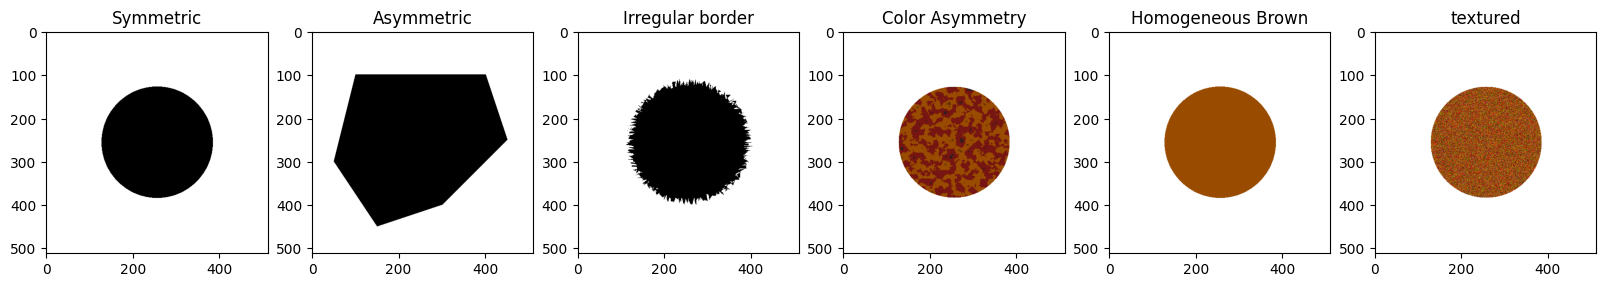

In [122]:
def create_blank_image(width, height, color='white', image_mode='1'):
    return Image.new(image_mode, (width, height), color)

def draw_circle(image, circle_center, circle_radius, color='black'):
    draw = ImageDraw.Draw(image)
    draw.ellipse((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
                  circle_center[0] + circle_radius, circle_center[1] + circle_radius),
                 fill=color)

# Create symmetric image
symmetric_img = create_blank_image(512, 512)
draw_circle(symmetric_img, (256, 256), 128)

# Create asymmetric image
asymmetric_img = create_blank_image(512, 512)
draw = ImageDraw.Draw(asymmetric_img)
polygon_points = [(100, 100), (400, 100), (450, 250), (300, 400), (150, 450), (50, 300)]
draw.polygon(polygon_points, fill='black')

# Create irregular image
irregular_img = create_blank_image(512, 512)
draw = ImageDraw.Draw(irregular_img)
circle_center = (256, 256)
radius = radius = min(512, 512) // 2 - 120
num_segments = 500
angle_step = 2 * math.pi / num_segments
points = [(circle_center[0] + (radius + random.uniform(-10, 10)) * math.cos(i * angle_step),
           circle_center[1] + (radius + random.uniform(-10, 10)) * math.sin(i * angle_step))
          for i in range(num_segments)]
draw.polygon(points, fill='black')

# Create color asymmetry image
colorasymmetry_img = create_blank_image(512, 512, image_mode='RGB')
draw = ImageDraw.Draw(colorasymmetry_img)
colors = [(197, 188, 217), (41, 31, 30), (118, 21, 17), (153, 76, 0), (102, 51, 0), (70, 130, 180)]
scale = 0.05
octaves = 4
persistence = 0.5
lacunarity = 2.0
for y in range(512):
    for x in range(512):
        dx = x - circle_center[0]
        dy = y - circle_center[1]
        distance = np.sqrt(dx * dx + dy * dy)
        if distance <= 128:
            noise_val = pnoise2(x * scale, y * scale, octaves, persistence, lacunarity)
            color_idx = int(((noise_val + 1) / 2) * len(colors)) % len(colors)
            draw.point((x, y), fill=colors[color_idx])

# Create homogeneous brown image
homogeneous_brown_img = create_blank_image(512, 512, image_mode='RGB')
draw_circle(homogeneous_brown_img, (256, 256), 128, color=(153, 76, 0))

# Create a textured circle image
def create_textured_circle_image(width, height, circle_center, circle_radius, color=(153, 76, 0), image_mode='RGB'):
    # Create a blank image
    image = Image.new(image_mode, (width, height), 'white')
    draw = ImageDraw.Draw(image)

    # Loop through each pixel in the image
    for y in range(height):
        for x in range(width):
            # Calculate the distance from the center of the circle
            dx = x - circle_center[0]
            dy = y - circle_center[1]
            distance = np.sqrt(dx * dx + dy * dy)

            # If the pixel is inside the circle, set its color with more random noise
            if distance <= circle_radius:
                noise = tuple(int(c + random.gauss(0, 50)) for c in color)  # Add more Gaussian noise to the color
                draw.point((x, y), fill=noise)

    return image

textured_circle_img = create_textured_circle_image(512, 512, (256, 256), 128)

# display all images side by side as Matplotlib figure with title for each image
fig, ax = plt.subplots(1, 6, figsize=(20, 20))
ax[0].imshow(symmetric_img, cmap='gray')
ax[0].set_title('Symmetric')
ax[1].imshow(asymmetric_img, cmap='gray')
ax[1].set_title('Asymmetric')
ax[2].imshow(irregular_img, cmap='gray')
ax[2].set_title('Irregular border')
ax[3].imshow(colorasymmetry_img)
ax[3].set_title('Color Asymmetry')
ax[4].imshow(homogeneous_brown_img)
ax[4].set_title('Homogeneous Brown')
ax[5].imshow(textured_circle_img)
ax[5].set_title('textured')
plt.show()

Asymmetry score:

In [123]:
def asymmetry_score_1(image_path):
    # if image_path is of type Image, then continue, else open the image
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')
    
    width, height = image.size

    # Calculate areas for each half along both axes
    area_top, area_bottom, area_left, area_right = 0, 0, 0, 0
    for y in range(height):
        for x in range(width):
            pixel_value = image.getpixel((x, y))
            if pixel_value == 0:  # Black pixel
                if y < height // 2:
                    area_top += 1
                else:
                    area_bottom += 1

                if x < width // 2:
                    area_left += 1
                else:
                    area_right += 1

    # Calculate the asymmetry scores for both axes
    vertical_asymmetry = abs(area_top - area_bottom) / (area_top + area_bottom)
    horizontal_asymmetry = abs(area_left - area_right) / (area_left + area_right)

    # Calculate the average asymmetry score
    average_asymmetry = (vertical_asymmetry + horizontal_asymmetry) / 2
    return average_asymmetry

# mask_path = 'your_mask_image_path.png'
print("Asymmetry score for Symmetric Image:", asymmetry_score_1(symmetric_img))
print("Asymmetry score for Asymmetric Image:", asymmetry_score_1(asymmetric_img))

Asymmetry score for Symmetric Image: 0.004955936517731453
Asymmetry score for Asymmetric Image: 0.09888327467903978


In [126]:
from scipy.ndimage import center_of_mass, rotate

def asymmetry_score_2(image_path, num_rotations=10):
    # if image_path is of type Image, then continue, else open the image
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')
    
    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Calculate the center of mass of the lesion
    center_of_mass_y, center_of_mass_x = center_of_mass(image_array)

    # Initialize the minimum asymmetry score to a large value
    min_asymmetry_score = float('inf')

    # Calculate the asymmetry score for several rotations of the image
    for angle in np.linspace(0, 180, num_rotations, endpoint=False):
        # Rotate the image
        rotated_image = rotate(image_array, angle, reshape=False)

        # Calculate areas for each half along both axes
        area_top, area_bottom, area_left, area_right = 0, 0, 0, 0
        for y in range(rotated_image.shape[0]):
            for x in range(rotated_image.shape[1]):
                pixel_value = rotated_image[y, x]
                if pixel_value == 0:  # Black pixel
                    if y < center_of_mass_y:
                        area_top += 1
                    else:
                        area_bottom += 1

                    if x < center_of_mass_x:
                        area_left += 1
                    else:
                        area_right += 1

        # Calculate the asymmetry scores for both axes
        vertical_asymmetry = abs(area_top - area_bottom) / (area_top + area_bottom)
        horizontal_asymmetry = abs(area_left - area_right) / (area_left + area_right)

        # Calculate the average asymmetry score
        average_asymmetry = (vertical_asymmetry + horizontal_asymmetry) / 2

        # Update the minimum asymmetry score
        min_asymmetry_score = min(min_asymmetry_score, average_asymmetry)

    return min_asymmetry_score

# mask_path = 'your_mask_image_path.png'
print("Asymmetry score for Symmetric Image:", asymmetry_score_2(symmetric_img))
print("Asymmetry score for Asymmetric Image:", asymmetry_score_2(asymmetric_img))

Asymmetry score for Symmetric Image: 0.002151980994385673
Asymmetry score for Asymmetric Image: 0.03195371544242798


Irregular border measurement:

In [127]:
import numpy as np
from PIL import Image
from skimage.measure import find_contours, label
from skimage.morphology import binary_closing

def border_irregularity_score(image_path):
    # Load the image and convert to a binary numpy array
    # if image_path is of type Image, then continue, else open the image
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')

    mask = np.array(image)

    # Close small gaps in the mask to get a better contour
    mask_closed = binary_closing(mask)

    # Find contours and take the longest one as the border
    contours = find_contours(mask_closed, 0.5)
    border = max(contours, key=len)

    # Calculate the perimeter of the border
    perimeter = 0
    for i in range(len(border) - 1):
        perimeter += np.linalg.norm(border[i + 1] - border[i])

    # Calculate the area of the mask
    area = np.sum(mask)

    # Calculate the border irregularity score (perimeter-to-area ratio)
    irregularity_score = perimeter / area
    return irregularity_score

print("Border irregularity score / Smooth:", border_irregularity_score(symmetric_img))
print("Border irregularity score / Irregular:", border_irregularity_score(irregular_img))

Border irregularity score / Smooth: 0.0040472901122593306
Border irregularity score / Irregular: 0.009908417142435103


Color irregularity measurement

In [128]:
def color_asymmetry_1(image):
    # Convert image to LAB color space
    lab_image = rgb2lab(image)

    # Get image dimensions
    height, width, _ = image.shape

    # Divide image into 3x3 blocks
    block_size = 3
    num_blocks_x = width // block_size
    num_blocks_y = height // block_size

    # Initialize list to store color averages
    color_avgs = []

    # Loop through each block
    for i in range(num_blocks_x):
        for j in range(num_blocks_y):
            # Get the block from the image
            block = lab_image[j*block_size:(j+1)*block_size, i*block_size:(i+1)*block_size, :]

            # Check if block is at least 75% inside lesion
            if np.sum(block[:, :, 0] < 90) >= (0.75 * block_size**2):
                # Compute color average for the block
                color_avg = np.mean(block, axis=(0, 1))
                color_avgs.append(color_avg)

    # Compute variance of color averages
    variances = np.var(color_avgs, axis=0)
    variance_score = np.mean(variances)
    
    # Clip variance score between 0 and 100
    variance_score = np.clip(variance_score, 0, 100)

    return variance_score

# Convert images to numpy arrays
homogeneous_brown_arr = np.array(homogeneous_brown_img)
colorasymmetry_arr = np.array(colorasymmetry_img)

# Call the color_symmetry function with the numpy arrays
print('Symmetric image:', color_asymmetry_1(homogeneous_brown_arr))
print('Asymmetric image:', color_asymmetry_1(colorasymmetry_arr))


Symmetric image: 0.5281182711691491
Asymmetric image: 61.097137226040765


In [129]:
import numpy as np
from skimage.color import rgb2lab
from skimage.transform import resize

def color_asymmetry_2(image):
    if isinstance(image, str):  # If image is a file path
        image = np.array(Image.open(image).convert('RGB'))
    elif isinstance(image, np.ndarray):  # If image is a NumPy array
        if image.dtype != np.uint8:
            raise ValueError("Invalid image array type. Expected dtype=np.uint8.")
        if image.ndim != 3 or image.shape[2] != 3:
            raise ValueError("Invalid image array shape. Expected shape=(H, W, 3).")
    else:
        raise ValueError("Invalid image type. Accepted types are file path or NumPy array.")

    # Convert image to LAB color space
    lab_image = rgb2lab(image)

    # Resize the image to a fixed size to standardize the calculation
    lab_image = resize(lab_image, (256, 256), mode='reflect', anti_aliasing=True)

    # Calculate the center line of the image
    center_line = lab_image.shape[1] // 2

    # Split the image into two halves along the center line
    left_half = lab_image[:, :center_line]
    right_half = lab_image[:, center_line:]

    # Flip the right half of the image horizontally
    right_half_flipped = np.fliplr(right_half)

    # Calculate the absolute difference between the two halves
    diff = np.abs(left_half - right_half_flipped)

    # Calculate the average color difference
    avg_color_diff = np.mean(diff)

    return avg_color_diff

homogeneous_brown_img_array = np.array(homogeneous_brown_img)
colorasymmetry_img_array = np.array(colorasymmetry_img)

print("Color symmetry score for Homogeneous Brown Image:", color_asymmetry_2(homogeneous_brown_img_array))
print("Color symmetry score for Color Asymmetry Image:", color_asymmetry_2(colorasymmetry_img_array))

Color symmetry score for Homogeneous Brown Image: 0.0901330200933926
Color symmetry score for Color Asymmetry Image: 1.7055218806917993


Texture

In [130]:
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import img_as_ubyte

def texture_score(image_path):
    # Load the image and convert to grayscale
    if isinstance(image_path, Image.Image):
        image = image_path.convert('L')
    else:
        image = Image.open(image_path).convert('L')

    # Convert the image to a numpy array and scale it to 8-bit (256 levels of gray)
    image = img_as_ubyte(np.array(image))

    # Calculate the GLCM of the image
    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    # Calculate texture properties from the GLCM
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Return the texture properties as a dictionary
    return {
        'contrast': contrast,
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,
        'energy': energy,
        'correlation': correlation
    }

print("Texture symmetry score for Homogeneous Brown Image:", texture_score(homogeneous_brown_img))
print("Texture symmetry score for Texture Asymmetry Image:", texture_score(textured_circle_img))

Texture symmetry score for Homogeneous Brown Image: {'contrast': 269.53991771449705, 'dissimilarity': 1.6335752588757395, 'homogeneity': 0.9900999075253618, 'energy': 0.8188248355808104, 'correlation': 0.9690343136660425}
Texture symmetry score for Texture Asymmetry Image: {'contrast': 649.0008398052267, 'dissimilarity': 8.49984590729783, 'homogeneity': 0.8021749275772788, 'energy': 0.7969466822290612, 'correlation': 0.9257736152277865}


Simplified version

For Contrast

In [137]:
def texture_score_contrast(image):
    # Convert the image to grayscale if it is in color
    if image.ndim == 3:
        image = rgb2gray(image)

    # Convert the image to a numpy array and scale it to 8-bit (256 levels of gray)
    image = img_as_ubyte(image)

    # Calculate the GLCM of the image
    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    # Calculate texture properties from the GLCM
    contrast = graycoprops(glcm, 'contrast')[0, 0]

    # Return the contrast value as the overall texture score
    return contrast

In [138]:
def texture_score_dissimilarity(image):
    # Convert the image to grayscale if it is in color
    if image.ndim == 3:
        image = rgb2gray(image)

    # Convert the image to a numpy array and scale it to 8-bit (256 levels of gray)
    image = img_as_ubyte(image)

    # Calculate the GLCM of the image
    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    # Calculate texture properties from the GLCM
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]

    # Return the dissimilarity value as the texture score
    return dissimilarity

Now, to skin lesion images

Load masked image function

Trial on two images, one is nevus, one is melanoma

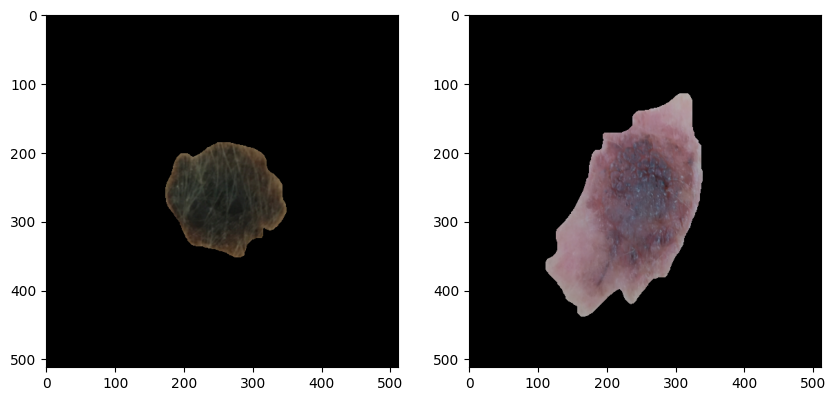

Symmetric image - Asymmetry_score_1: 0.11086770168587484
Asymmetric image - Asymmetry_score_1: 0.22727272727272727
Symmetric image - Asymmetry_score_2: 0.029835922291525964
Asymmetric image - Asymmetry_score_2: 0.07464716687205003
Symmetric image - Border_irregularity_score: 0.0024359869079820847
Asymmetric image - Border_irregularity_score: 0.00440119844074832
Symmetric image - Color_asymmetry_1: 15.446734269655993
Asymmetric image - Color_asymmetry_1: 100.0
Symmetric image - Color_asymmetry_2: 0.43946373016834817
Asymmetric image - Color_asymmetry_2: 3.1536080587480684
Symmetric image - Texture_score_constrast: 57.248736439842205
Asymmetric image - Texture_score_constrast 325.3891148915188
Symmetric image - Texture_score_dissimilarity: 1.274015347633136
Asymmetric image - Texture_score_dissimilarity: 3.273129314595661


In [133]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def load_masked_image(image_path, mask_path):
    # read image in BGR
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    masked_image = cv2.bitwise_and(image, image, mask=mask) # apply mask to image
    return masked_image


image_path = '..\\data\\images_resized\\PAT_710_1330_243.PNG'
mask_path = '..\\data\\shanon_masks_total\\PAT_710_1330_243.PNG'
image = Image.open(image_path)
mask = Image.open(mask_path)
masked_image = load_masked_image(image_path, mask_path)
inverted_mask = cv2.bitwise_not(np.array(mask))
masked_image_arr = np.array(masked_image)
gray_image = cv2.cvtColor(masked_image_arr, cv2.COLOR_RGB2GRAY)


image_path1 = '..\\data\\images_resized\\PAT_975_1834_152.PNG'
mask_path1 = '..\\data\\shanon_masks_total\\PAT_975_1834_152.PNG'
image1 = Image.open(image_path1)
mask1 = Image.open(mask_path1)
masked_image1 = load_masked_image(image_path1, mask_path1)
inverted_mask1 = cv2.bitwise_not(np.array(mask1))
masked_image1_arr = np.array(masked_image1)
gray_image1 = cv2.cvtColor(masked_image1_arr, cv2.COLOR_RGB2GRAY)


# Convert NumPy array back to PIL Image
inverted_mask = Image.fromarray(inverted_mask)
inverted_mask1 = Image.fromarray(inverted_mask1)

# display
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.subplot(1, 2, 2)
plt.imshow(masked_image1)
plt.show()

print('Symmetric image - Asymmetry_score_1:', asymmetry_score_1(inverted_mask))
print('Asymmetric image - Asymmetry_score_1:', asymmetry_score_1(inverted_mask1))
print('Symmetric image - Asymmetry_score_2:', asymmetry_score_2(inverted_mask))
print('Asymmetric image - Asymmetry_score_2:', asymmetry_score_2(inverted_mask1))
print('Symmetric image - Border_irregularity_score:', border_irregularity_score(inverted_mask))
print('Asymmetric image - Border_irregularity_score:', border_irregularity_score(inverted_mask1))
print('Symmetric image - Color_asymmetry_1:', color_asymmetry_1(masked_image))
print('Asymmetric image - Color_asymmetry_1:', color_asymmetry_1(masked_image1))
print('Symmetric image - Color_asymmetry_2:', color_asymmetry_2(masked_image))
print('Asymmetric image - Color_asymmetry_2:', color_asymmetry_2(masked_image1))
print('Symmetric image - Texture_score_constrast:', texture_score_contrast(gray_image))
print('Asymmetric image - Texture_score_constrast', texture_score_contrast(gray_image1))
print('Symmetric image - Texture_score_dissimilarity:', texture_score_dissimilarity(gray_image))
print('Asymmetric image - Texture_score_dissimilarity:', texture_score_dissimilarity(gray_image1))

Assessment of algorithmic measurements vs. manual measurements for 5 samples as proof of concept

Manuual measurement of 5 skin lesions is stored in ../data/manual_measurement.csv

In [143]:
filename = '../data/manual_measurement.csv'

with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip the header row
    data = []
    for row in reader:
        data.append(row[:4])

print(data)

[['PAT_340_714_314.png', '2', '6', '4'], ['PAT_627_1188_503.png', '0', '2', '2.5'], ['PAT_710_1330_243.png', '1', '2', '1'], ['PAT_801_1518_574.png', '1', '4', '3'], ['PAT_975_1834_152.png', '2', '5', '5']]


append algo_asymmetric score to data:

In [144]:
for i in data:
    filename = i[0]
    image_path = os.path.join('../data/Manual_feature_images', filename)
    mask_path = os.path.join('../data/Manual_feature_masks', filename)
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    masked_image = load_masked_image(image_path, mask_path)
    inverted_mask = cv2.bitwise_not(np.array(mask))
    inverted_mask = Image.fromarray(inverted_mask)
    masked_image_arr = np.array(masked_image)
    gray_image = cv2.cvtColor(masked_image_arr, cv2.COLOR_RGB2GRAY)


    # calc asymmetry
    asymmetry_1 = asymmetry_score_1(inverted_mask)
    asymmetry_2 = asymmetry_score_2(inverted_mask)
    
    # calc border irregularity
    border_irregularity = border_irregularity_score(inverted_mask)
    
    # calc color asymmetry
    color_asymmetry_score_1 = color_asymmetry_1(masked_image)
    color_asymmetry_score_2 = color_asymmetry_2(masked_image)
    
    # texture
    texture_contrast_score = texture_score_contrast(gray_image)
    texture_dissimilarity = texture_score_dissimilarity(gray_image)
    
    # append these scores to data for this row
    i.append(asymmetry_1)
    i.append(asymmetry_2)
    i.append(border_irregularity)
    i.append(color_asymmetry_score_1)
    i.append(color_asymmetry_score_2)
    i.append(texture_contrast_score)
    i.append(texture_dissimilarity)

for i in data:
    print(i)


['PAT_340_714_314.png', '2', '6', '4', 0.07407609228723694, 0.029034532543186664, 0.008971265483439825, 73.9445134548536, 3.2775354368610388, 232.79554209812622, 4.412637142504931]
['PAT_627_1188_503.png', '0', '2', '2.5', 0.06350803553460023, 0.03116036301509428, 0.0033949502878729476, 71.35600227397475, 1.8630888516500368, 152.46545241617358, 1.810882026627219]
['PAT_710_1330_243.png', '1', '2', '1', 0.12556681138446696, 0.03311443342182479, 0.0024461762668463974, 15.323729355724494, 0.44438781175686914, 56.13211908284022, 1.2632057445759368]
['PAT_801_1518_574.png', '1', '4', '3', 0.06522427023178547, 0.007183758459135867, 0.0037298512560259797, 28.009709467885358, 1.1090565462119377, 140.52332193047334, 2.1268645216962523]
['PAT_975_1834_152.png', '2', '5', '5', 0.23036497003309775, 0.05658978487772668, 0.0049532805779638304, 100.0, 3.112112951357824, 337.9096092209073, 3.3701846030572002]


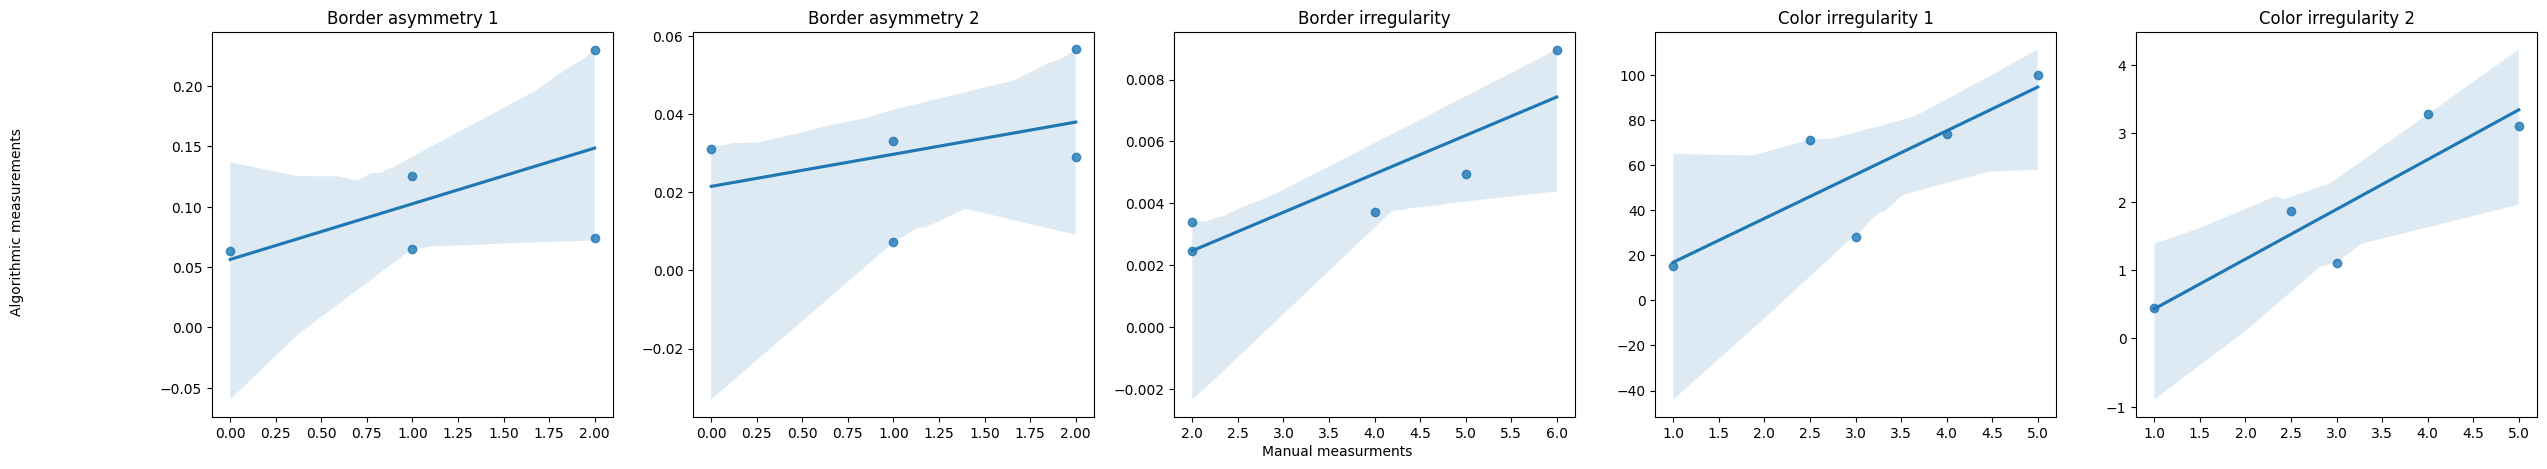

In [151]:
# extract data from columns
col1 = [float(row[1]) for row in data] # manual asymmetry
col2 = [float(row[2]) for row in data] # manual border irregularity
col3 = [float(row[3]) for row in data] # manual color asymmetry
col4 = [float(row[4]) for row in data] # asymmetry_1
col5 = [float(row[5]) for row in data] # asymmetry_2
col6 = [float(row[6]) for row in data] # border_irregularity
col7 = [float(row[7]) for row in data] # color_asymmetry_score_1
col8 = [float(row[8]) for row in data] # color_asymmetry_score_2

# Create 5 subplots for each pair of columns
# col1 to col 4
# col1 to col 5
# col2 to col 6
# col3 to col 7
# col3 to col 8
fig, axs = plt.subplots(1, 5, figsize=(30, 5))

# Set common axis labels
fig.text(0.5, 0.04, 'Manual measurments', ha='center', va='center')
fig.text(0.06, 0.5, 'Algorithmic measurements', ha='center', va='center', rotation='vertical')

# Plot scatter plot and regression line for each pair of columns
sns.regplot(x=col1, y=col4, ax=axs[0])
sns.regplot(x=col1, y=col5, ax=axs[1])
sns.regplot(x=col2, y=col6, ax=axs[2])
sns.regplot(x=col3, y=col7, ax=axs[3])
sns.regplot(x=col3, y=col8, ax=axs[4])

# Set subplot titles
axs[0].set_title('Border asymmetry 1')
axs[1].set_title('Border asymmetry 2')
axs[2].set_title('Border irregularity')
axs[3].set_title('Color irregularity 1')
axs[4].set_title('Color irregularity 2')

plt.show()

Algorithmically extract (1) Border Asymmetry Score, (2) Irregular Border Score, (3) Color Irregularity Score (4) Texture score 
from all images where my have labeled masks

Create a CSV file with all the features

In [ ]:
filename = 'MEL_ids.csv'

# Extract the IDs from the CSV file
mel_ids = []
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        mel_ids.append(row[0])

# Write the IDs to a new CSV file with a 'diagnosis' column
with open('features_output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_id', 'diagnosis'])
    for mel_id in mel_ids:
        writer.writerow([mel_id, 'MEL'])

filename_sek = 'SEK_ids.csv'
sek_ids = []
with open(filename_sek, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # Skip the header row
    for row in reader:
        sek_ids.append(row[0])

with open('features_output.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for sek_id in sek_ids:
        writer.writerow([sek_id, 'SEK'])

add asymmetry, border_irregularity, color_irregularity to features_output.csv
In addition, add selected features from metadata.csv to features_output.csv

In [ ]:
with open('features_output.csv', 'r+', newline='') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)
    header.append('asymmetry')
    header.append('border_irregularity')
    header.append('color_asymmetry')
    header.append('diameter_avg')
    header.append('smoke')
    header.append('age')
    header.append('itch')

    rows = []
    for row in reader:
        rows.append(row)
        
    for i, row in enumerate(rows):
        # if image does not exist, then continue
        if not os.path.exists(os.path.join('../data/images_resized', row[0])):
            continue
        image_path = os.path.join('../data/images_resized', row[0])
        mask_path = os.path.join('../data/shanon_masks_total', row[0])
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        mask_inverted = ImageOps.invert(mask)
        
        # calc asymmetry
        asymmetry = asymmetry_score(mask)
        # calc border irregularity
        border_irregularity = border_irregularity_score(mask_inverted)
        # calc color asymmetry
        masked_image = load_masked_image(image_path, mask_path)
        masked_image_arr = np.array(masked_image)
        color_asymmetry = color_symmetry(masked_image)
        
        rows[i].append(asymmetry)
        rows[i].append(border_irregularity)
        rows[i].append(color_asymmetry)

        with open('../data/metadata.csv', newline='') as metafile:
            meta_reader = csv.reader(metafile)
            next(meta_reader)  # Skip the header row
            for meta_row in meta_reader:
                if meta_row[24] == row[0]:
                    # Append new values to the row
                    diameter_avg = (float(meta_row[15]) + float(meta_row[16])) / 2
                    rows[i].append(diameter_avg)
                    rows[i].append(meta_row[2])
                    rows[i].append(meta_row[6])
                    rows[i].append(meta_row[18])
                    break  # Stop searching after finding a match

    # Write the updated rows to the file
    csvfile.seek(0)  # Rewind the file pointer
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for row in rows:
        writer.writerow(row)